# Comment Toxicity 
## Anja Matic, Emma Moncia, Mija Pilkaite


- BagOfwords method
- TFIDF
- Using Logistic, SGD, Descion Tree
- If time sbert

## What we are trying to obtain and our approach to do so

   The program we are building is going to be able to recognize for each input, respectively for each comment from the database, whether the comment is in fact toxic or not. Further, our model will classify them into 5 types of toxic comments: severe toxicity, obscene, threat, insult and identity attack. Our program's goal is to detect toxic comments and minimize unintended model bias with respect to mentions of identities. We will be using a dataset labeled for identity mentions and optimizing a metric designed to measure unintended bias.
   Our goal is to develop strategies in order to reduce unintended bias in machine learning models, and create a program that will work well for a wide range of conversations and online formus. In our implementation we will use the Logistic Regression Classification method as well as the Stochastic Gradient Descent (SGD) and Decision Trees methods. As for our sentences conversion and the preprocessing of sentences we will be implementing three different methods: Bag of Words (BOW), TF-IDF (Term Frequency - Inverse Document Frequency), respectively the more advanced embedding Sbert.



In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import re
#from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
#import sentence_transformers

We will use a wikipedia forum database Discussing things you care about can be difficult. 
The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments. 
This dataset consists of a large number of Wikipedia comments which have been labeled by human raters for toxic behavior.

Data Fields
id: id of the comment

comment_text: the text of the comment
toxic: value of 0(non-toxic) or 1(toxic) classifying the comment

severe_toxic: value of 0(non-severe_toxic) or 1(severe_toxic) classifying the comment

obscene: value of 0(non-obscene) or 1(obscene) classifying the comment

threat: value of 0(non-threat) or 1(threat) classifying the comment

insult: value of 0(non-insult) or 1(insult) classifying the comment

identity_hate: value of 0(non-identity_hate) or 1(identity_hate) classifying the comment

In [2]:
train_df = pd.read_csv('train.csv', index_col='id')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [75]:
test_df = pd.read_csv('test.csv', index_col='id')
test_df.head(10)
test_df.shape

(153164, 1)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                       

In [5]:
train_df.isnull().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

We have quite a few null values for classification of toxicity by group (such as asian, atheist, bisexual and so on), however we might not necessarily have to use these values so we do not have to drop it. 

In [6]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (1804874, 44) (97320, 1)


Target value represents the level of toxicity of a comment, thus here as we can see the comments are mostly not toxic as the value is well below 0.5.

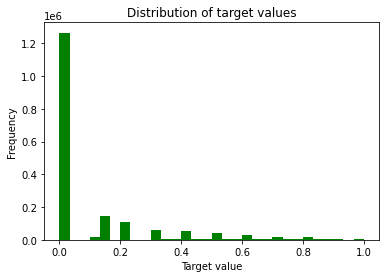

In [7]:
# extract the values of the column you want to plot
values = train_df['target']

# plot the histogram
plt.hist(values, bins=30, color='green')
plt.title('Distribution of target values')
plt.xlabel('Target value')
plt.ylabel('Frequency')
plt.show()

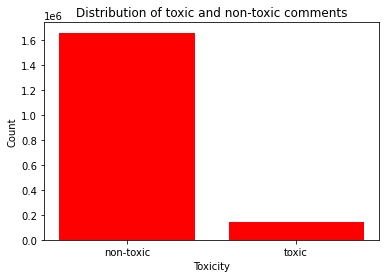

In [8]:
toxicity = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")
counts = toxicity.value_counts()

plt.title('Distribution of toxic and non-toxic comments')
plt.bar(counts.index, counts.values, color = 'red')
plt.xlabel("Toxicity")
plt.ylabel("Count")
plt.show()

We can see that there is quite a bit of imbalance in the dataset, as the majority of the comments are classified as non-toxic. 

# PREPROCESSING

Preprocessing of the comments

In [9]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    try :
        text_string = text_string.lower() # Convert everything to lower case.
        text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
        
        x = text_string.split()
        new_text = []
        
        for word in x:
            if word not in stop_words:
                new_text.append(stemmer.stem(word))
                
        text_string = ' '.join(new_text)
    except :
        text_string= str(text_string)
        text_string = text_string.lower() # Convert everything to lower case.
        text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
        
        x = text_string.split()
        new_text = []
        
        for word in x:
            if word not in stop_words:
                new_text.append(stemmer.stem(word))
                
        text_string = ' '.join(new_text)
    return text_string

In [10]:
# lemmatizer = WordNetLemmatizer()
# def preprocess_lemma(text_string):
#     try :
#         text_string = text_string.lower() # Convert everything to lower case.
#         text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
        
#         x = text_string.split()
#         new_text = []
        
#         for word in x:
#             if word not in stop_words:
#                 new_text.append(stemmer.stem(word))
                
#         text_string = ' '.join(new_text)
#     except :
#         text_string= str(text_string)
#         text_string = text_string.lower() # Convert everything to lower case.
#         text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
        
#         x = text_string.split()
#         new_text = []
        
#         for word in x:
#             if word not in stop_words:
#                 new_text.append(lemmatizer.lemmatize(word))
                
#         text_string = ' '.join(new_text)
#     return text_string

In [11]:
#first use target value to split the comments into toxic and non-toxic ones
toxic_df = train_df[train_df['target'] >= 0.5]
non_toxic_df = train_df[train_df['target'] < 0.5]
#now balance the dataset by making the non_toxic_df same sized as toxic_df by randomly sampling from it
non_toxic_df = non_toxic_df.sample(n=toxic_df.shape[0], random_state=42)
#now concatenate the two dataframes
train_df = pd.concat([toxic_df, non_toxic_df])
#shuffle the dataframe
train_df = train_df.sample(frac=1, random_state=42)

In [12]:
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

In [13]:
#train_df['preprocessed_text_lemma'] = train_df['comment_text'].apply(preprocess)

In [14]:
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(train_df[['preprocessed_text']], train_df[['target']])

In [16]:
y_train['target bin'] = round(y_train['target'])
y_val['target bin'] =  round(y_val['target'])
print(y_val['target'].ravel().shape)

(72167,)


In [17]:
y_train['target bin'] = round(y_train['target'])
y_val['target bin'] =  round(y_val['target'])

In [18]:
X_train_bal, X_val_bal, y_train_bal, y_val_bal = train_test_split(train_df[['preprocessed_text']], train_df[['target']])

In [19]:
y_train_bal['target bin'] = round(y_train_bal['target'])
y_val_bal['target bin'] =  round(y_val_bal['target'])

### Function for hyperparameter tuning SGD

In [20]:
def SGD_hyper_tune(alphas, norm, x_train, x_val, Y_train = y_train, Y_val = y_val, best_model = None, best_error = math.inf):
    """Hyperparameter tuning for SGD."""
    train_err = []
    val_err = []
    best_model = None
    best_error = math.inf

    for a in alphas:
        #print(f'Penalty: {norm}, Learning rate: {a}')
        
        model = SGDRegressor(alpha=a, penalty=norm) 
        model.fit(x_train, Y_train["target"]) # Train
        
        preds = model.predict(x_train) # Get predictions
        err = mean_squared_error(Y_train['target'], preds) # Calculate error on trainset
        train_err.append(err)
        #print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(x_val) # Get predictions on CV set
        err = mean_squared_error(Y_val['target'], preds) # Calculate error on cv set
        val_err.append(err)

        #print("Mean Squared Error on validation set set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
    return train_err, val_err, best_model, best_error

In [21]:
def DecTree_hyper_tune(x_train, x_val, max_depths, min_samples, Y_train = y_train, Y_val = y_val ):
    
    tr_errors = []
    val_errors = []
    xticks = []

    best_model = None
    best_error = math.inf

    for d in max_depths:
        for samp in min_samples:
            xticks.append(f'Max_depth: {d}, min_samples: {samp}')
            #print(f'Max_depth: {d}, min_samples: {samp}')
        
            model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
            model.fit(x_train, Y_train['target']) # Train
        
            preds = model.predict(x_train) # Get predictions
            err = mean_squared_error(Y_train['target'], preds) # Calculate error on trainset
            tr_errors.append(err)
            #print("Mean Squared Error on train set: ", err)
        
            preds = model.predict(x_val) # Get predictions on CV set
            err = mean_squared_error(Y_val['target'], preds) # Calculate error on cv set
            val_errors.append(err)
            #print("Mean Squared Error on cv set: ", err)
        
            if err < best_error: # Get best model trained
                best_error = err
                best_model = model
    return tr_errors, val_errors, best_model, best_error, xticks
        

## 1. BAG OF WORDS (BOW)

In [22]:
count_vect = CountVectorizer(ngram_range=(1,2), max_features=30000)
#Convert a collection of text documents to a matrix of token counts 
#nram_range = The lower and upper boundary of the range, (1,2)-unigrams and bigrams
bow_train = count_vect.fit_transform(X_train['preprocessed_text'])
bow_val = count_vect.transform(X_val['preprocessed_text'])

print(bow_train.shape)
print(bow_val.shape)


(1353655, 30000)
(451219, 30000)


In [24]:
count_vect_lemma = CountVectorizer(max_features=30000)
#Convert a collection of text documents to a matrix of token counts 
#nram_range = The lower and upper boundary of the range, (1,2)-unigrams and bigrams
bow_train_lemma = count_vect.fit_transform(X_train['preprocessed_text'])
bow_val_lemma = count_vect.transform(X_val['preprocessed_text'])

### 1.1 SGD



In [25]:
#Hyperparameters for tuning
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
train_err_l1_bow, val_err_l1_bow, best_model, best_error = SGD_hyper_tune(alphas, 'l1', bow_train, bow_val)
train_err_l2_bow, val_err_l2_bow, best_model, best_error = SGD_hyper_tune(alphas, 'l2', bow_train, bow_val, best_model, best_error)        

TypeError: 'SGDRegressor' object is not subscriptable

In [ ]:
train_err_l1_bow_lemma, val_err_l1_bow_lemma, best_model_lemma, best_error_lemma = SGD_hyper_tune(alphas, 'l1', bow_train_lemma, bow_val_lemma)
train_err_l2_bow_lemma, val_err_l2_bow_lemma, best_model_lemma, best_error_lemma = SGD_hyper_tune(alphas, 'l2', bow_train_lemma, bow_val_lemma, 
                                                                                                  best_model_lemma, best_error_lemma)

Penalty: l1, Learning rate: 1e-05
Mean Squared Error on train set:  11.704401089270162
Mean Squared Error on validation set set:  2.0970659190175005
Penalty: l1, Learning rate: 0.0001
Mean Squared Error on train set:  0.038880614721354644
Mean Squared Error on validation set set:  0.03871351199965633
Penalty: l1, Learning rate: 0.001
Mean Squared Error on train set:  0.038880565403897165
Mean Squared Error on validation set set:  0.03871364424819947
Penalty: l1, Learning rate: 0.01
Mean Squared Error on train set:  0.0388806021333097
Mean Squared Error on validation set set:  0.03871352777643213
Penalty: l1, Learning rate: 0.1
Mean Squared Error on train set:  0.03888056996390116
Mean Squared Error on validation set set:  0.03871360843589905
Penalty: l1, Learning rate: 1
Mean Squared Error on train set:  0.03888056508683254
Mean Squared Error on validation set set:  0.038713698935351856
Penalty: l1, Learning rate: 10
Mean Squared Error on train set:  0.03888056541122397
Mean Squared Er

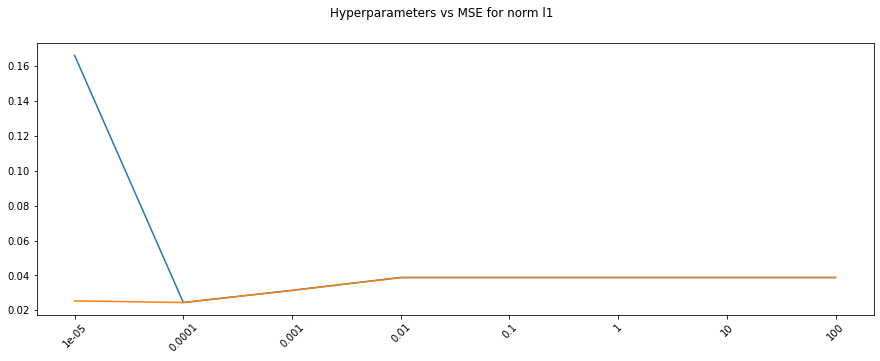

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE for norm l1")
plt.plot(range(len(alphas)), train_err_l1_bow)
plt.plot(range(len(alphas)), val_err_l1_bow)
plt.xticks(range(len(alphas)), alphas, rotation=45)


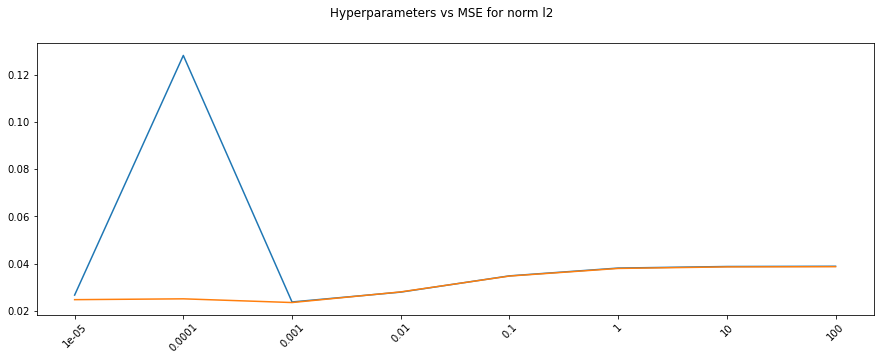

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE for norm l2")
plt.plot(range(len(alphas)), train_err_l2_bow)
plt.plot(range(len(alphas)), val_err_l2_bow)
plt.xticks(range(len(alphas)), alphas, rotation=45)

In [ ]:
print(f'Best error : {best_error}')

Best error : 0.023501425959752784


In [ ]:
best_model_SGD_BOW = best_model

In [ ]:
# Getting the best model parameters:
best_model.get_params()

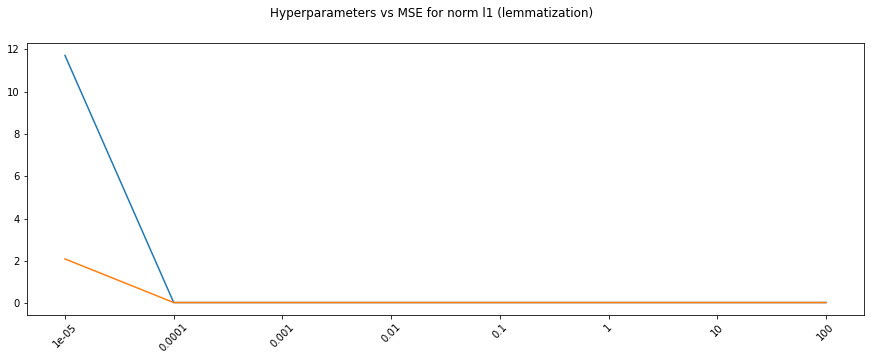

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE for norm l1 (lemmatization)")
plt.plot(range(len(alphas)), train_err_l1_bow_lemma)
plt.plot(range(len(alphas)), val_err_l1_bow_lemma)
plt.xticks(range(len(alphas)), alphas, rotation=45)


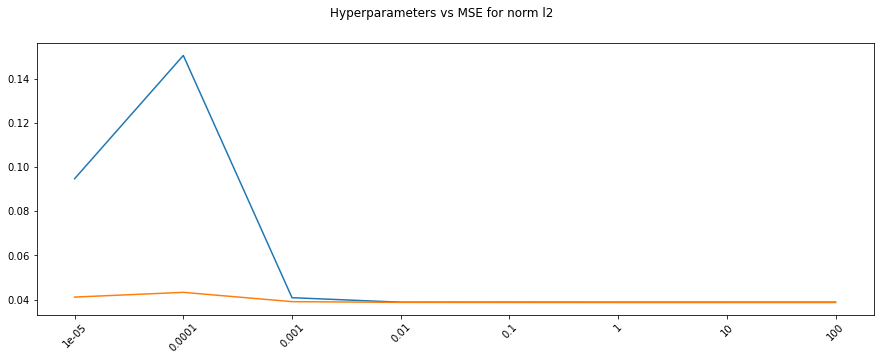

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE for norm l2")
plt.plot(range(len(alphas)), train_err_l2_bow_lemma)
plt.plot(range(len(alphas)), val_err_l2_bow_lemma)
plt.xticks(range(len(alphas)), alphas, rotation=45)

In [ ]:

print(f'Best error, lemma : {best_error_lemma}')

Best error, lemma : 0.0387138035808795


In [ ]:
best_model_SGD_BOW_lemma = best_model_lemma

##### 1.1.2 Feature Importance:

In [ ]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = count_vect.get_feature_names()
weights = best_model_SGD_BOW.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idiot,0.379735
stupid,0.326922
pathet,0.240077
moron,0.239682
crap,0.221889
hypocrit,0.221629
dumb,0.220717
fool,0.190618
clown,0.185234
damn,0.184603


In [ ]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
great great,-0.179321
stupid stupid,-0.061991
black white,-0.030844
ignor fact,-0.024584
fool peopl,-0.023463
knee jerk,-0.023005
white hous,-0.022516
black market,-0.020476
winner loser,-0.020049
mental health,-0.017811


In [ ]:
df.describe()

,weights
count,30000.000000
mean,0.000402
std,0.007718
min,-0.179321
25%,-0.001418
50%,-0.000242
75%,0.000954
max,0.379735


### 1.2 Logistics Regresssion

In [ ]:
model = sklearn.linear_model.LogisticRegression(solver='newton-cg', multi_class='multinomial',max_iter=1000, random_state=42)
model.fit(bow_train, y_train['target bin'])
y_pred = model.predict(bow_val)


In [ ]:
print(sklearn.metrics.accuracy_score(y_val['target bin'].tolist(), y_pred))

0.9571937351928886


In [ ]:
best_model_linear_BOW = model

### 1.3 Decison Trees

In [ ]:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
train_err, val_err, best_model_DecTr_BOW, best_error, xticks = DecTree_hyper_tune(bow_train, bow_val, max_depths=max_depth, min_samples= min_samples)

Max_depth: 3, min_samples: 10
Mean Squared Error on train set:  0.03311082208088345
Mean Squared Error on cv set:  0.03309350756933867
Max_depth: 3, min_samples: 100
Mean Squared Error on train set:  0.03311082208088345
Mean Squared Error on cv set:  0.033093507569338675
Max_depth: 3, min_samples: 1000
Mean Squared Error on train set:  0.03311291433116807
Mean Squared Error on cv set:  0.03309536610232462
Max_depth: 5, min_samples: 10
Mean Squared Error on train set:  0.032031809019118763
Mean Squared Error on cv set:  0.03202550192334972
Max_depth: 5, min_samples: 100
Mean Squared Error on train set:  0.03203458550461031
Mean Squared Error on cv set:  0.032023852045778387
Max_depth: 5, min_samples: 1000
Mean Squared Error on train set:  0.03206096036405618
Mean Squared Error on cv set:  0.03204900456548376
Max_depth: 7, min_samples: 10


KeyboardInterrupt: 

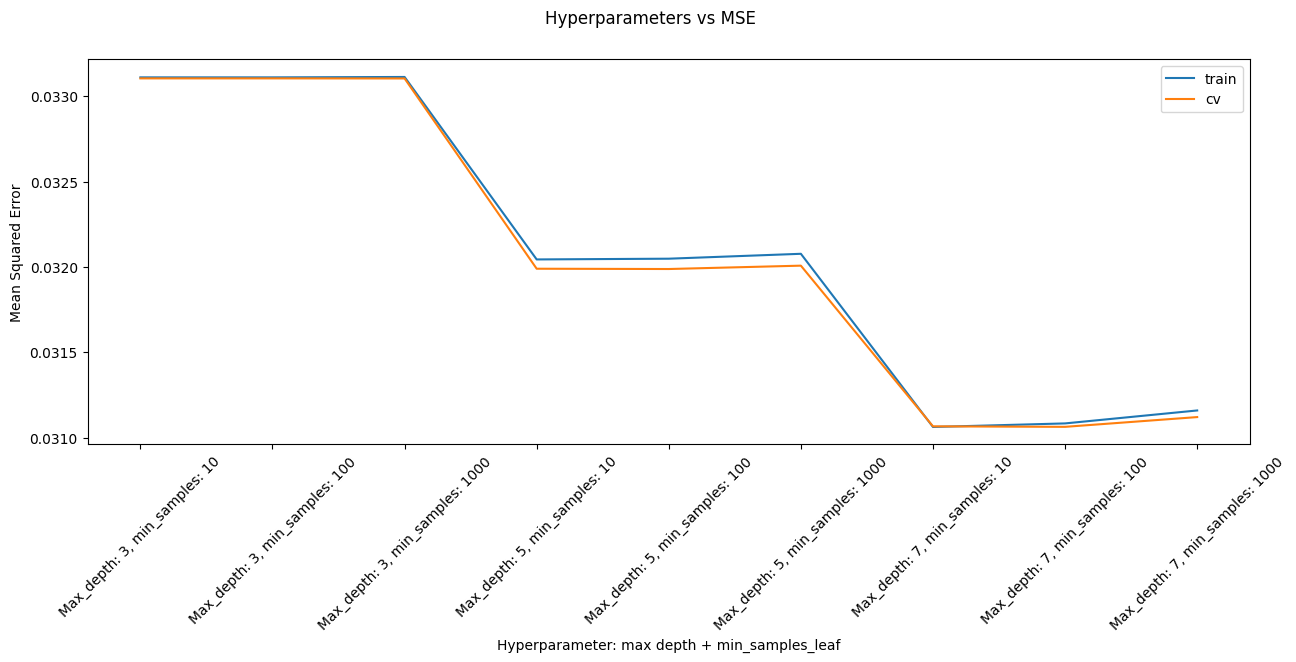

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), train_err)
plt.plot(range(len(max_depth) * len(min_samples)), val_err)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
# Best models parameters:
best_model_DecTr_BOW.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

#### 1.3.1 Feature Importance:

In [ ]:
weights = best_model_DecTr_BOW.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.397019
idiot,0.264248
pathet,0.071346
fool,0.068473
moron,0.061643
racist,0.060010
hypocrit,0.056055
year,0.004414
would,0.003926
one,0.003147


In [ ]:
df.sort_values("weights", ascending=True).iloc[0:20,:]

### 1.4 BOW with n_gram_range = (1,1)

In [ ]:
count_vect_2 = CountVectorizer(max_features=30000)
#Convert a collection of text documents to a matrix of token counts 
#nram_range = The lower and upper boundary of the range, (1,2)-unigrams and bigrams
bow_train = count_vect_2.fit_transform(X_train['preprocessed_text'])
bow_val = count_vect_2.transform(X_val['preprocessed_text'])

In [ ]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
train_err_l1_bow, val_err_l1_bow, best_model_2, best_error_2 = SGD_hyper_tune(alphas, 'l1', bow_train, bow_val)
train_err_l2_bow, val_err_l2_bow, best_model_2, best_error_2 = SGD_hyper_tune(alphas, 'l2', bow_train, bow_val, best_model_2, best_error_2)

Penalty: l1, Learning rate: 1e-05
Mean Squared Error on train set:  0.02291643371400611
Mean Squared Error on validation set set:  0.023002886102200207
Penalty: l1, Learning rate: 0.0001
Mean Squared Error on train set:  0.024477421854738824
Mean Squared Error on validation set set:  0.024461055923398846
Penalty: l1, Learning rate: 0.001
Mean Squared Error on train set:  0.03144139666654059
Mean Squared Error on validation set set:  0.03141357344914696
Penalty: l1, Learning rate: 0.01
Mean Squared Error on train set:  0.038880568180495206
Mean Squared Error on validation set set:  0.03871361899917938
Penalty: l1, Learning rate: 0.1
Mean Squared Error on train set:  0.03888059925566247
Mean Squared Error on validation set set:  0.038713884310184715
Penalty: l1, Learning rate: 1
Mean Squared Error on train set:  0.03888056438830384
Mean Squared Error on validation set set:  0.03871367275144842
Penalty: l1, Learning rate: 10
Mean Squared Error on train set:  0.0388805708274658
Mean Square

In [ ]:
print(best_error_2)

0.022788669672439813


In [ ]:
feat_names = count_vect_2.get_feature_names()
weights = best_model_2.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idiot,0.416264
stupid,0.351351
moron,0.312514
pathet,0.296421
crap,0.277892
hypocrit,0.275914
ass,0.272432
shit,0.266596
scum,0.266004
dumb,0.262219


In [ ]:
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
magaph,-0.052944
knee,-0.035469
can,-0.031034
winner,-0.024858
gerald,-0.023816
cattl,-0.023109
condol,-0.022073
therein,-0.020880
reaction,-0.019928
awesom,-0.019352


In [ ]:
count_vect_3 = CountVectorizer(max_features=3000)
#Convert a collection of text documents to a matrix of token counts 
#nram_range = The lower and upper boundary of the range, (1,2)-unigrams and bigrams
bow_train = count_vect_3.fit_transform(X_train['preprocessed_text'])
bow_val = count_vect_3.transform(X_val['preprocessed_text'])

In [ ]:
train_err_l1_bow, val_err_l1_bow, best_model_2, best_error_2 = SGD_hyper_tune(alphas, 'l1', bow_train, bow_val)
train_err_l2_bow, val_err_l2_bow, best_model_2, best_error_2 = SGD_hyper_tune(alphas, 'l2', bow_train, bow_val, best_model_2, best_error_2)

Penalty: l1, Learning rate: 1e-05
Mean Squared Error on train set:  0.024493123970832715
Mean Squared Error on validation set set:  0.024518397998901337
Penalty: l1, Learning rate: 0.0001
Mean Squared Error on train set:  0.02511647449723944
Mean Squared Error on validation set set:  0.025090773203699894
Penalty: l1, Learning rate: 0.001
Mean Squared Error on train set:  0.03145929121903961
Mean Squared Error on validation set set:  0.031431267735100465
Penalty: l1, Learning rate: 0.01
Mean Squared Error on train set:  0.03888058139030016
Mean Squared Error on validation set set:  0.03871381330251603
Penalty: l1, Learning rate: 0.1
Mean Squared Error on train set:  0.0388805785024153
Mean Squared Error on validation set set:  0.038713575344156044
Penalty: l1, Learning rate: 1
Mean Squared Error on train set:  0.03888057745723723
Mean Squared Error on validation set set:  0.0387135785281563
Penalty: l1, Learning rate: 10
Mean Squared Error on train set:  0.03888056751200488
Mean Squared

In [ ]:
feat_names = count_vect.get_feature_names()
weights = best_model_SGD_BOW.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idiot,0.379735
stupid,0.326922
pathet,0.240077
moron,0.239682
crap,0.221889
hypocrit,0.221629
dumb,0.220717
fool,0.190618
clown,0.185234
damn,0.184603


In [ ]:
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
great great,-0.179321
stupid stupid,-0.061991
black white,-0.030844
ignor fact,-0.024584
fool peopl,-0.023463
knee jerk,-0.023005
white hous,-0.022516
black market,-0.020476
winner loser,-0.020049
mental health,-0.017811


In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
#build a neural network model fully connected to predict the target bin (toxic or non-toxic)
#input layer: 30000 neurons, hidden layer: 100 neurons, output layer: 2 neurons
from tensorflow.keras.utils import to_categorical

# One-hot encode the target labels
y_train_one_hot = to_categorical(y_train['target bin'])
y_val_one_hot = to_categorical(y_val['target bin'])

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(30000,)))
model.add(Dense(2, activation='softmax'))
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

# Train the model
history = model.fit(bow_train, y_train_one_hot,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(bow_val, y_val_one_hot))

# Evaluate the model
score = model.evaluate(bow_val, y_val_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               3000100   
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 3,000,302
Trainable params: 3,000,302
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
10575/10576 [============================>.] - ETA: 0s - loss: 0.1282 - accuracy: 0.9586

KeyboardInterrupt: 

## 2. TF-IDF (Term Frequency - Inverse Document Frequency)

In [34]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features= 30000) 
#ngram_range: how many words in a row we consdier, make sense to consider more than one word at a time in this case  
tfid_train = tfidf_vectorizer.fit_transform(X_train['preprocessed_text'])
tfid_val = tfidf_vectorizer.transform(X_val['preprocessed_text'])

print(tfid_train.shape)
print(tfid_val.shape)

(216501, 30000)
(72167, 30000)


In [35]:
tfidf_vect_bal = TfidfVectorizer(ngram_range=(1, 2), max_features= 30000)
tfid_train_bal = tfidf_vect_bal.fit_transform(X_train_bal['preprocessed_text'])
tfid_val_bal = tfidf_vect_bal.transform(X_val_bal['preprocessed_text'])

In [29]:
def sparse_matrix_to_sparse_tensor(sparse_matrix):
    indices = np.array(sparse_matrix.nonzero()).T
    values = sparse_matrix.data
    dense_shape = sparse_matrix.shape
    return tf.sparse.SparseTensor(indices, values, dense_shape)

tfid_train_bal_sparse = sparse_matrix_to_sparse_tensor(tfid_train_bal)
tfid_val_bal_sparse = sparse_matrix_to_sparse_tensor(tfid_val_bal)

In [31]:
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import RMSprop

def sparse_matrix_to_sparse_tensor(sparse_matrix):
    indices = np.array(sparse_matrix.nonzero()).T
    values = sparse_matrix.data
    dense_shape = sparse_matrix.shape
    return tf.sparse.SparseTensor(indices, values, dense_shape)

# Convert sparse matrices to TensorFlow SparseTensors
tfid_train_bal_sparse = sparse_matrix_to_sparse_tensor(tfid_train_bal)
tfid_val_bal_sparse = sparse_matrix_to_sparse_tensor(tfid_val_bal)
tfid_train_bal_sparse = tf.sparse.reorder(tfid_train_bal_sparse)
tfid_val_bal_sparse = tf.sparse.reorder(tfid_val_bal_sparse)

# One-hot encode the target labels
y_train_one_hot = to_categorical(y_train['target bin'])
y_val_one_hot = to_categorical(y_val['target bin'])

# Define the model
inputs = Input(shape=(tfid_train_bal.shape[1],), sparse=True)
x = Dense(100, activation='relu')(inputs)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

# Train the model
history = model.fit(tfid_train_bal_sparse, y_train_one_hot,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(tfid_val_bal_sparse, y_val_one_hot))

# Evaluate the model
score = model.evaluate(tfid_val_bal_sparse, y_val_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_8 (Dense)             (None, 100)               3000100   
                                                                 
 dense_9 (Dense)             (None, 2)                 202       
                                                                 
Total params: 3,000,302
Trainable params: 3,000,302
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1692/1692 [==============================] - 37s 21ms/step - loss: 0.6593 - accuracy: 0.6322 - val_loss: 0.6609 - val_accuracy: 0.6283
Epoch 2/10
1692/1692 [==============================] - 35s 20ms/step - loss: 0.6548 - accuracy: 0.6323 - val_loss: 0.6637 - val_accuracy: 0.6283
Epoch 3/10
1692/1692 

### 2.1 SGD

#### 2.1.1 Unbalanced dataset

In [ ]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
train_err_l1_tfidf, val_err_l1_tfidf, best_model, best_error = SGD_hyper_tune(alphas, 'l1', tfid_train, tfid_val)
train_err_l2_tfidf, val_err_l2_tfidf, best_model, best_error = SGD_hyper_tune(alphas, 'l2', tfid_train, tfid_val, 
                                                                  best_model = best_model, best_error = best_error)        

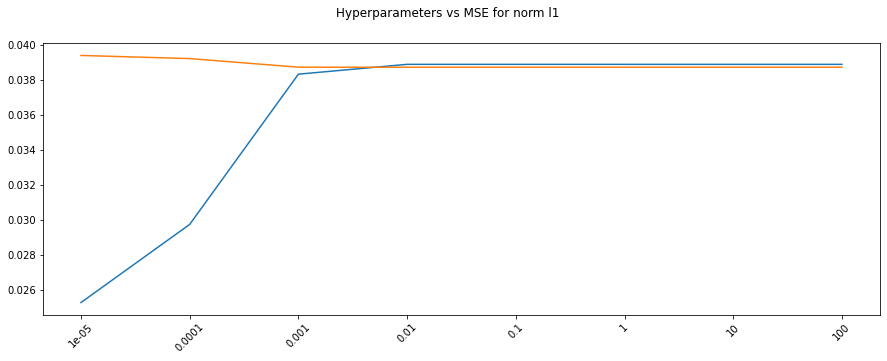

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE for norm l1")
plt.plot(range(len(alphas)), train_err_l1_tfidf)
plt.plot(range(len(alphas)), val_err_l1_tfidf)
plt.xticks(range(len(alphas)), alphas, rotation=45);


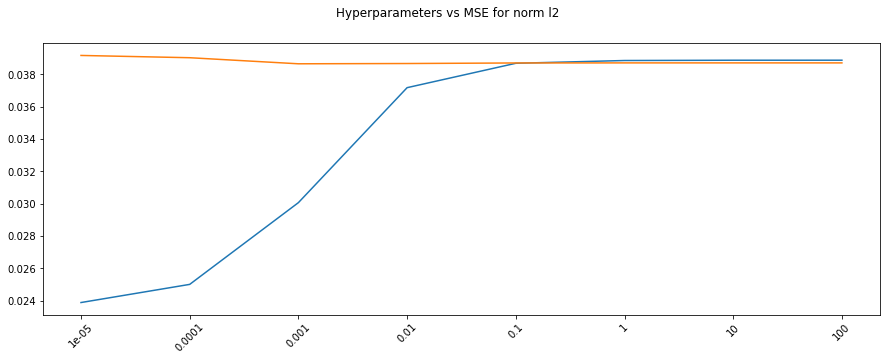

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE for norm l2")
plt.plot(range(len(alphas)), train_err_l2_tfidf)
plt.plot(range(len(alphas)), val_err_l2_tfidf)
plt.xticks(range(len(alphas)), alphas, rotation=45);

In [ ]:
print(f'Best error : {best_error}')


Best error : 0.03865823222969164


In [ ]:
best_model_SGD_TFIDF = best_model

##### 2.1.1. Feature Importance:

In [ ]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vectorizer.get_feature_names()
weights = best_model_SGD_TFIDF.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
sweatshop,0.736472
greed,0.570486
greenhorn,0.289549
dod,0.283579
whack,0.268687
riddler,0.253426
percol,0.244622
cn,0.242558
ktva,0.237416
sato,0.232521


In [ ]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thumbnail,-0.071693
hayden,-0.052970
yor,-0.052572
300k,-0.051646
exposur,-0.051496
winnipegg,-0.049578
figurehead,-0.045729
neato,-0.045459
brave,-0.044929
abject,-0.044926


#### 2.1.2 Balanced dataset

In [ ]:
train_err_l1_tfidf_bal, val_err_l1_tfidf_bal, best_model_bal, best_error_bal = SGD_hyper_tune(alphas, 'l1', tfid_train_bal, tfid_val_bal, Y_train= y_train_bal, Y_val = y_val_bal)
train_err_l2_tfidf_bal, val_err_l2_tfidf_bal, best_model_bal, best_error_bal = SGD_hyper_tune(alphas, 'l2', tfid_train_bal, tfid_val_bal, Y_train= y_train_bal, Y_val = y_val_bal, 
                                                                  best_model = best_model_bal, best_error = best_error_bal)        

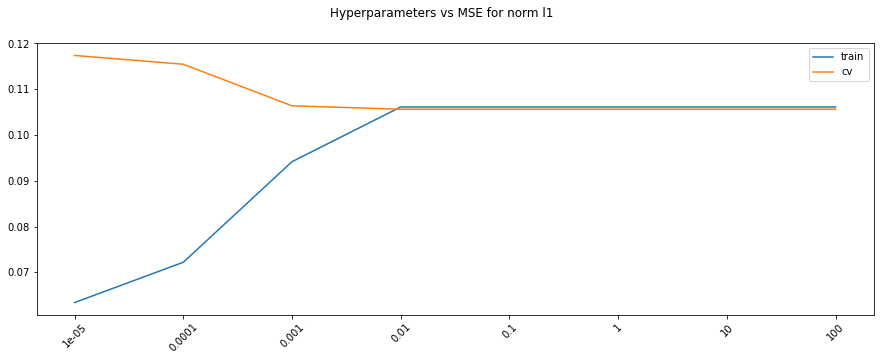

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE for norm l1")
plt.plot(range(len(alphas)), train_err_l1_tfidf_bal)
plt.plot(range(len(alphas)), val_err_l1_tfidf_bal)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alphas)), alphas, rotation=45);

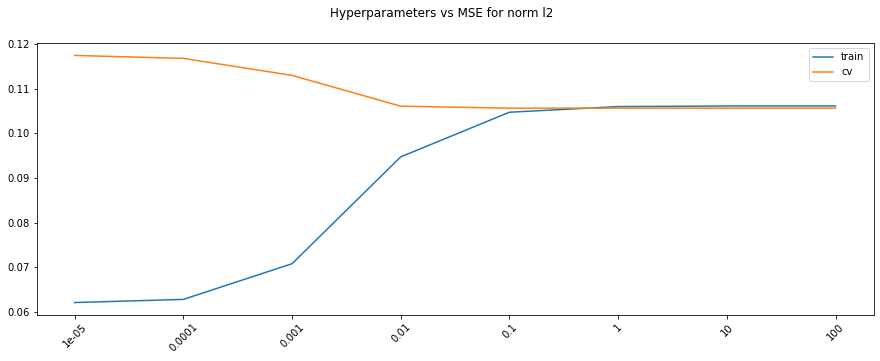

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE for norm l2")
plt.plot(range(len(alphas)), train_err_l2_tfidf_bal)
plt.plot(range(len(alphas)), val_err_l2_tfidf_bal)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alphas)), alphas, rotation=45);

In [ ]:
print(f'Best error : {best_error_bal}')

Best error : 0.10561837917787548


In [ ]:
best_model_SGD_TFIDF_bal = best_model

##### 2.1.2.1 Features

In [ ]:
feat_names = tfidf_vectorizer.get_feature_names()
weights = best_model_SGD_TFIDF_bal.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
sweatshop,0.736472
greed,0.570486
greenhorn,0.289549
dod,0.283579
whack,0.268687
riddler,0.253426
percol,0.244622
cn,0.242558
ktva,0.237416
sato,0.232521


In [ ]:
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thumbnail,-0.071693
hayden,-0.052970
yor,-0.052572
300k,-0.051646
exposur,-0.051496
winnipegg,-0.049578
figurehead,-0.045729
neato,-0.045459
brave,-0.044929
abject,-0.044926


### 2.2 Logistics Regression

#### 2.2.1 Unbalanced dataset

In [ ]:
model = sklearn.linear_model.LogisticRegression(solver='newton-cg', multi_class='multinomial',max_iter=1000, random_state=42)
model.fit(tfid_train, y_train['target bin'])
y_pred = model.predict(tfid_val)


In [ ]:
print(sklearn.metrics.accuracy_score(y_val['target bin'].tolist(), y_pred))

0.9374516587289099


In [ ]:
weights = model.coef_[0]
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idea make,16.814230
substitut,16.593556
moratorium,9.303627
shoulda,8.888166
cpa,8.826856
patriot,8.678679
hut,8.186916
illeg vote,8.056395
dud,7.837176
jefferson,7.769042


In [ ]:
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
klastri,-3.108026
follow link,-2.308040
ghetto,-1.855247
arar,-1.770518
blair,-1.722938
winner take,-1.602376
can,-1.425541
humour,-1.374695
withdraw,-1.374007
general welfar,-1.366008


#### 2.2.2 Balanced dataset

In [ ]:
model = sklearn.linear_model.LogisticRegression(solver='newton-cg', multi_class='multinomial',max_iter=1000, random_state=42)
model.fit(tfid_train_bal, y_train_bal['target bin'])
y_pred = model.predict(tfid_val_bal)

In [ ]:
print(sklearn.metrics.accuracy_score(y_val_bal['target bin'].tolist(), y_pred))

0.620823922291352


In [ ]:
weights = model.coef_[0]
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
tierney,15.475149
incept,15.168524
onyoutub,8.593609
chilliwack,8.160729
rata,7.408211
staffer,7.390331
dialog,7.382700
feminin,6.957678
alewa,6.815343
implic,6.621640


In [ ]:
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
038,-1.186734
patchouli,-1.179008
endzon,-1.170787
effus,-1.104623
ryanc,-1.069871
unchristian,-1.063372
65th,-1.061305
scrubber,-1.049600
whiner,-1.039834
cah,-1.036725


### 2.3 Decision Tree

#### 2.3.1 Unbalanced dataset

In [ ]:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
train_err_tfidf, val_err_tfidf, best_model_DecTr_TFIDF, best_error, xticks = DecTree_hyper_tune(tfid_train, tfid_val, max_depths=max_depth, min_samples= min_samples)

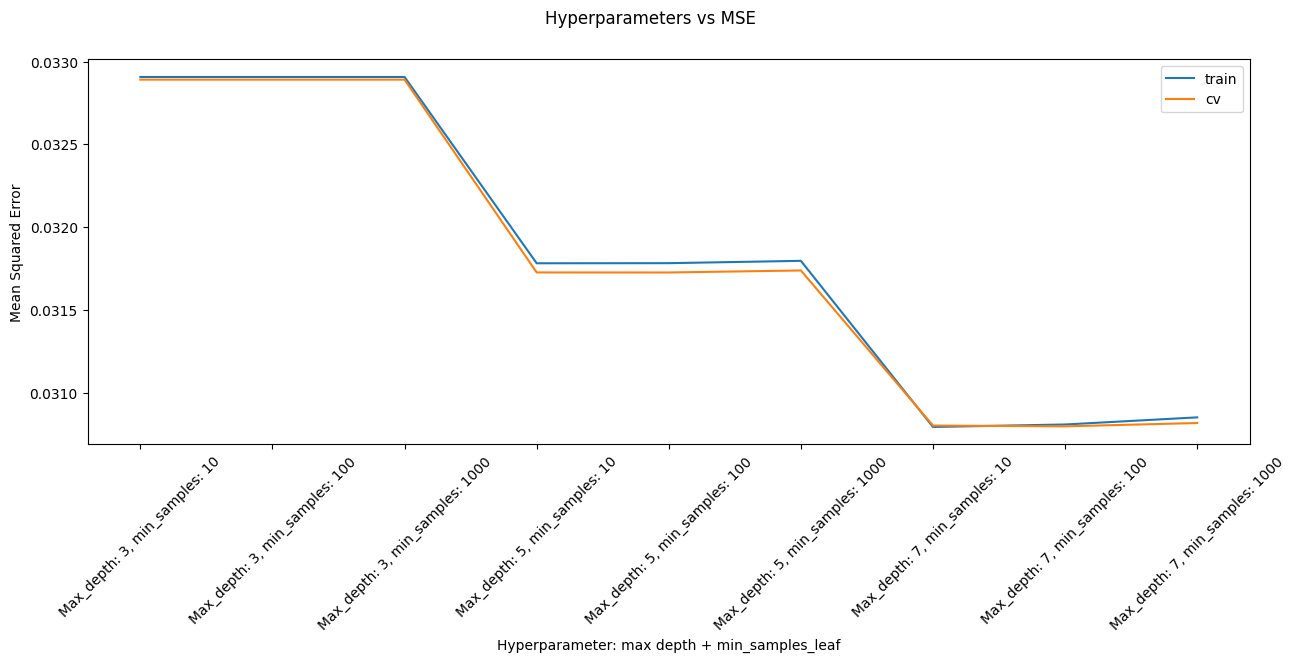

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), train_err_tfidf)
plt.plot(range(len(max_depth) * len(min_samples)), val_err_tfidf)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

#### 2.3.1.2 Feauture importance

In [ ]:
weights = best_model_DecTr_TFIDF.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

#### 2.3.1 Balanced dataset

In [ ]:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
train_err_tfidf, val_err_tfidf, best_model_DecTr_TFIDF, best_error, xticks = DecTree_hyper_tune(tfid_train_bal, tfid_val_bal, max_depths=max_depth, 
                                                                                                min_samples= min_samples, Y_train=y_train_bal, Y_val=y_val_bal)

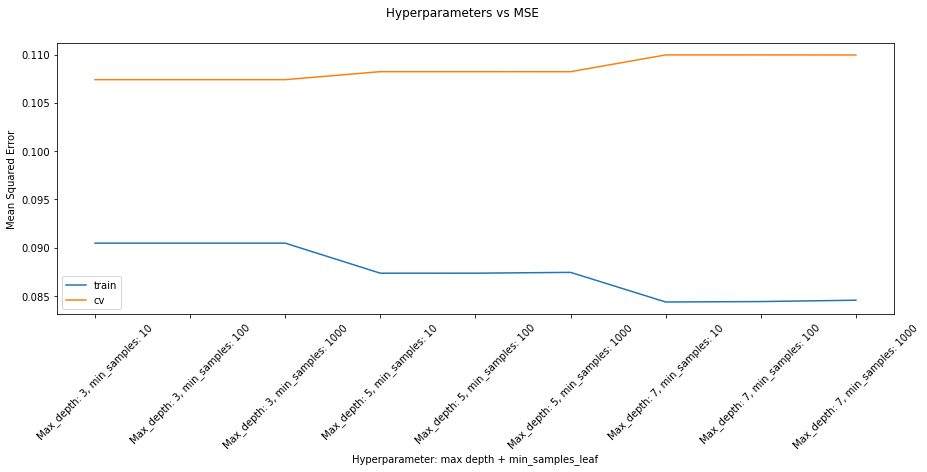

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), train_err_tfidf)
plt.plot(range(len(max_depth) * len(min_samples)), val_err_tfidf)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
print("Best error: ", best_error )

Best error:  0.10739690908553803


In [ ]:
weights = best_model_DecTr_TFIDF.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
tierney,0.506548
incept,0.377666
feminin,0.115786
00,0.000000
rawi,0.000000
rb,0.000000
razor,0.000000
raze,0.000000
raza,0.000000
raytheon,0.000000


In [ ]:
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
00,0.0
rb,0.0
razor,0.0
raze,0.0
raza,0.0
raytheon,0.0
raymond,0.0
raygun,0.0
raybould,0.0
ray,0.0


### 2.4 Testing the models

In [ ]:
test_df.describe()

,comment_text,preprocessed_text
count,153164,153164
unique,153164,150274
top,""" \n\n Welcome! \n\n Hello, and welcome to Wik...",
freq,1,896


In [ ]:
test_df.columns

Index(['comment_text', 'preprocessed_text'], dtype='object')

In [ ]:
comment_vec = tfidf_vectorizer.transform(test_df['preprocessed_text'])

In [ ]:
prediction_sgd = best_model_SGD_TFIDF_bal.predict(comment_vec[:10])

In [ ]:
prediction_lr = model.predict(comment_vec[:10])

In [ ]:
pred_tree = best_model_DecTr_TFIDF.predict(comment_vec[:10])

In [ ]:
for i in range(10):  
    print("Comment: " , test_df["comment_text"][i])
    print(f'Toxicity: SGD: {prediction_sgd[i]}, LR: {prediction_lr[i]}, Tree: {pred_tree[i]}')
    print("*"*50)

Comment:  Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,
Toxicity: SGD: 0.09061060699396381, LR: 0.0, Tree: 0.314287419857905
**************************************************
Comment:  == From RfC == 

 The title is fine as it is, IMO.
Toxicity: SGD: 0.09057236596900475, LR: 0.0, Tree: 0.314287419857905
**************************************************
Comment:  " 

 == Sources == 

 * Zawe Ashton on Lapland —  /  "
Toxicity: SGD: 0.0965535991524512, LR: 0.0, Tree: 0.314287419857905
**************************************************
Comment:  :If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't upda

## 3. SBERT classification

In [76]:
#take 5 random toxic comments and 5 random non-toxic comments
test_df_example = test_df[:10]
for i in range(10):  
    print("Comment: " , test_df_example["comment_text"].iloc[i])
    print("*"*50)

#print(train_df_example['comment_text'])

Comment:  Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,
**************************************************
Comment:  == From RfC == 

 The title is fine as it is, IMO.
**************************************************
Comment:  " 

 == Sources == 

 * Zawe Ashton on Lapland —  /  "
**************************************************
Comment:  :If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message.
**************************************************
Comment:  I don't anonymously edit articles at all.
************************

In [91]:
# train_df_sample = pd.read_pickle("train_df_sample.pkl")
# test_df_sample = pd.read_pickle("test_df_sample.pkl")



AttributeError: Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from 'c:\\Users\\mijap\\anaconda3\\lib\\site-packages\\pandas\\_libs\\internals.cp38-win_amd64.pyd'>

In [79]:
test_example = test_df[:10]

In [ ]:
#take 1000 random datapoints from the training set
#train_df_sample = train_df.sample(n=1000, random_state=1)

In [92]:
#take 500 points that are toxic and 500 points that are non-toxic
train_df_sample = pd.concat([train_df[train_df['target'] < 0.5].sample(n=4000, random_state=1)
                                , train_df[train_df['target'] >= 0.5].sample(n=4000, random_state=1)])
test_df_sample = test_df.sample(n=100, random_state=1)


In [94]:

import sentence_transformers
model = sentence_transformers.SentenceTransformer('all-MiniLM-L6-v2')
comment_embeddings_train = model.encode(train_df_sample['comment_text'].tolist())
comment_embeddings_test = model.encode(test_df_sample['comment_text'].tolist())
train_df_sample['comment_embeddings'] = list(comment_embeddings_train)
test_df_sample['comment_embeddings'] = list(comment_embeddings_test)

Most important words:

In [ ]:
comment_embeddings = np.array(train_df_sample['comment_embeddings'].tolist())

references = train_df_sample['comment_text'].tolist()
vectorizer = CountVectorizer()

vectorizer.fit_transform(references)
vocabulary = vectorizer.vocabulary_
word_importance = {}

for i in range(comment_embeddings.shape[1]):

    embedding_values = comment_embeddings[:, i]
    correlation = np.corrcoef(embedding_values, vectorizer.transform(references).toarray()[:, i])[0, 1]
    word = list(vocabulary.keys())[list(vocabulary.values()).index(i)]
    word_importance[word] = correlation
sorted_word_importance = {k: v for k, v in sorted(word_importance.items(), key=lambda item: item[1], reverse=True)}

for i, (word, score) in enumerate(sorted_word_importance.items()):
    if i == 30:
        break
    print(f'{i+1}. {word}: {score}')

1. access: 0.06164292656206879
2. accepted: 0.06160185176465183
3. 100yrs: 0.05954594964188065
4. 70: 0.05813593118386331
5. 250: 0.058095643049226826
6. abrahmic: 0.056066789046661174
7. 99: 0.05234923897964235
8. 06: 0.050904025824107135
9. 3_ydgsy77xy: 0.05028536096803715
10. accessing: 0.04939089330472881
11. absolute: 0.04919872351864526
12. accounts: 0.046962712644844695
13. 60k: 0.04536599858198654
14. 16: 0.04286781888630138
15. 816: 0.04226605105635562
16. 78: 0.03965486246480703
17. 20et: 0.03931834994323564
18. 2009: 0.039218166471852
19. 487b38f63dd3: 0.03890136377262997
20. 167: 0.03833129027565605
21. accordingly: 0.03701110521287633
22. 650: 0.035804871642152625
23. abstinence: 0.03556718016081333
24. accelerated: 0.03556075987608879
25. according: 0.035474257105715244
26. 1795: 0.035458763209037014
27. 47: 0.03539782549308676
28. abandoned: 0.03514660239458338
29. 40k: 0.03443358307107285
30. account: 0.034294704302218815


In [98]:
#add a label column to the dataframe to indicate whether the comment is toxic or
#  not, meaning that the target value is greater than 0.5
train_df_sample['label'] = train_df_sample['target'].apply(lambda x: 1 if x >= 0.5 else 0)
train_df_bert = train_df_sample[['comment_embeddings', 'label', 'target']]



In [99]:
#this split is for classification
feature_c = train_df_sample[['comment_embeddings']]
output_c = train_df_sample[['label']]
X_train_c, X_cv_c, y_train_c, y_cv_c = train_test_split(feature_c, output_c, test_size=0.2, random_state=42)
#X_test = test_df_sample[['comment_embeddings']]

### 3.2 Logistic Regression:

In [107]:
model = sentence_transformers.SentenceTransformer('all-MiniLM-L6-v2')
example_embed = model.encode(test_df_example['comment_text'].tolist())


In [108]:
X_train_c_flat = np.vstack(X_train_c['comment_embeddings'].values)
X_cv_c_flat = np.vstack(X_cv_c['comment_embeddings'].values)

model = sklearn.linear_model.LogisticRegression(solver='newton-cg', max_iter=1000, random_state=42)
model.fit(X_train_c_flat, y_train_c.values.ravel())
y_pred = model.predict(X_cv_c_flat)
print("Accuracy:",sklearn.metrics.accuracy_score(y_cv_c, y_pred))


Accuracy: 0.773125


c:\Users\mijap\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\mijap\anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


In [111]:
predictions = model.predict(example_embed)
#print first 3 predictions of test example and the corresponding comments
for i in range(10):
    print(f'Prediction: {predictions[i]}, Comment: {test_df_example["comment_text"].iloc[i]}')
    print("*"*50)

Prediction: 1, Comment: Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,
**************************************************
Prediction: 0, Comment: == From RfC == 

 The title is fine as it is, IMO.
**************************************************
Prediction: 0, Comment: " 

 == Sources == 

 * Zawe Ashton on Lapland —  /  "
**************************************************
Prediction: 0, Comment: :If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message.
**************************************************
Prediction: 0, Comme

In [56]:
#train_df is the original train_df from train.csv file
#this split is for regression
feature_r = train_df_bert[['comment_embeddings']]
output_r = train_df_bert[['target']]
X_train_r, X_cv_r, y_train_r, y_cv_r = train_test_split(feature_r, output_r, test_size=0.2, random_state=42)
#X_test_r = test_df[['comment_embeddings']]

### 3.1 SGD Regression:

In [57]:
# Flatten the 'comment_embeddings' column in both X_train_r and X_cv_r
X_train_r_flat = np.vstack(X_train_r['comment_embeddings'].values)
X_cv_r_flat = np.vstack(X_cv_r['comment_embeddings'].values)

alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(X_train_r_flat, y_train_r.values.ravel()) # Train
        
        preds = model.predict(X_train_r_flat) # Get predictions
        err = mean_squared_error(y_train_r['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(X_cv_r_flat) # Get predictions on CV set
        err = mean_squared_error(y_cv_r['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*" * 50)

1e-05 l1 :
Mean Squared Error on train set:  0.08409214541932172
Mean Squared Error on cv set:  0.08390834338057529
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.08501312337497502
Mean Squared Error on cv set:  0.0847490907913458
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.08579807422033843
Mean Squared Error on cv set:  0.08563471842577756
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.08509117909054624
Mean Squared Error on cv set:  0.08489101636879706
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.09335008375456554
Mean Squared Error on cv set:  0.09332967263501889
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.08514665307307907
Mean Squared Error on cv set:  0.08490740278903842
************************************************

In [58]:
best_model.get_params()

{'alpha': 1e-05,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l1',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [113]:
best_model.predict(example_embed)
#print first 10 comments and the corresponding predictions
for i in range(10):
    print(f'Prediction: {best_model.predict(example_embed)[i]}, Comment: {test_df_example["comment_text"].iloc[i]}')
    print("*"*50)

Prediction: 0.4298309252190684, Comment: Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,
**************************************************
Prediction: 0.30106953878544657, Comment: == From RfC == 

 The title is fine as it is, IMO.
**************************************************
Prediction: 0.2960395160626292, Comment: " 

 == Sources == 

 * Zawe Ashton on Lapland —  /  "
**************************************************
Prediction: 0.23173856490826655, Comment: :If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message.
*

In [65]:
#run the best model on the df_example
predict_values = np.vstack(train_df_example['comment_embeddings'].values)
y_pred = best_model.predict(predict_values)
#print the comment text and the predicted toxicity score
for i in range(len(y_pred)):
    print(train_df_example['comment_text'].iloc[i])
    print(f'Predicted: {y_pred[i]}')
    #also print true toxicity score
    print(train_df_example['target'].iloc[i])

Complicit banks must be named, shamed and slam-dunked.
Predicted: 0.38420356610220574
0.2
It appears that Rona Ambrose accompanied her partner rather than leading a delegation such as Trudeau did.

It also appears that Rona Ambrose consulted the ethics commissioner about this trip unlike Trudeau who blindly assumed he was entitled to do whatever he pleased.

Big difference in morals and ethics here.
Predicted: 0.2996731215172869
0.0
Part of the problem is that BC isn't getting a lot of the financial benefits.  According to the Conference Board of Canada, BC is only getting 12% of the benefits.  So we get an increase in risk all for what?  A paltry sum.  Seems like a raw deal to me.  

To be fair, transporting oil by pipeline is far safer than by rail which is what is currently being done.  However, I haven't seen any quantitative figures on the risks regarding this pipeline - and the tankers.

Ultimately, this is the lesser of many evils.  It could be worse, we could be talking about c

### 3.3 Decision Trees

In [ ]:
max_depth = [1, 5, 10, 50, 100, 500, 1000]
min_samples_split = [5, 10, 100, 500]
min_samples_leaf = [1, 5, 10, 20, 50]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100

for d in max_depth:
    for s in min_samples_split:
        for l in min_samples_leaf:
            xticks.append(str(d) + ' ' + str(s) + ' ' + str(l))
            print(str(d) + ' ' + str(s) + ' ' + str(l) + " :")
            
            model = DecisionTreeRegressor(max_depth=d, min_samples_split=s, min_samples_leaf=l)
            model.fit(X_train_r_flat, y_train_r.values.ravel()) # Train
            
            preds = model.predict(X_train_r_flat) # Get predictions
            err = mean_squared_error(y_train_r['target'], preds) # Calculate error on trainset
            tr_errors.append(err)
            print("Mean Squared Error on train set: ", err)
            
            preds = model.predict(X_cv_r_flat) # Get predictions on CV set
            err = mean_squared_error(y_cv_r['target'], preds) # Calculate error on cv set
            cv_errors.append(err)
            print("Mean Squared Error on cv set: ", err)
            
            if err < best_error: # Get best model trained
                best_error = err
                best_model = model
            
            print("*" * 50)


1 5 1 :
Mean Squared Error on train set:  0.09862189963818803
Mean Squared Error on cv set:  0.10670105767072728
**************************************************
1 5 5 :
Mean Squared Error on train set:  0.09862189963818803
Mean Squared Error on cv set:  0.10670105767072728
**************************************************
1 5 10 :
Mean Squared Error on train set:  0.09862189963818803
Mean Squared Error on cv set:  0.10670105767072728
**************************************************
1 5 20 :
Mean Squared Error on train set:  0.09862189963818803
Mean Squared Error on cv set:  0.10670105767072728
**************************************************
1 5 50 :
Mean Squared Error on train set:  0.09862189963818803
Mean Squared Error on cv set:  0.10670105767072728
**************************************************
1 10 1 :
Mean Squared Error on train set:  0.09862189963818803
Mean Squared Error on cv set:  0.1067010576707273
**************************************************
1 10 5 :
Mean

C:\Users\monci\AppData\Local\Temp\ipykernel_31732\3220242184.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


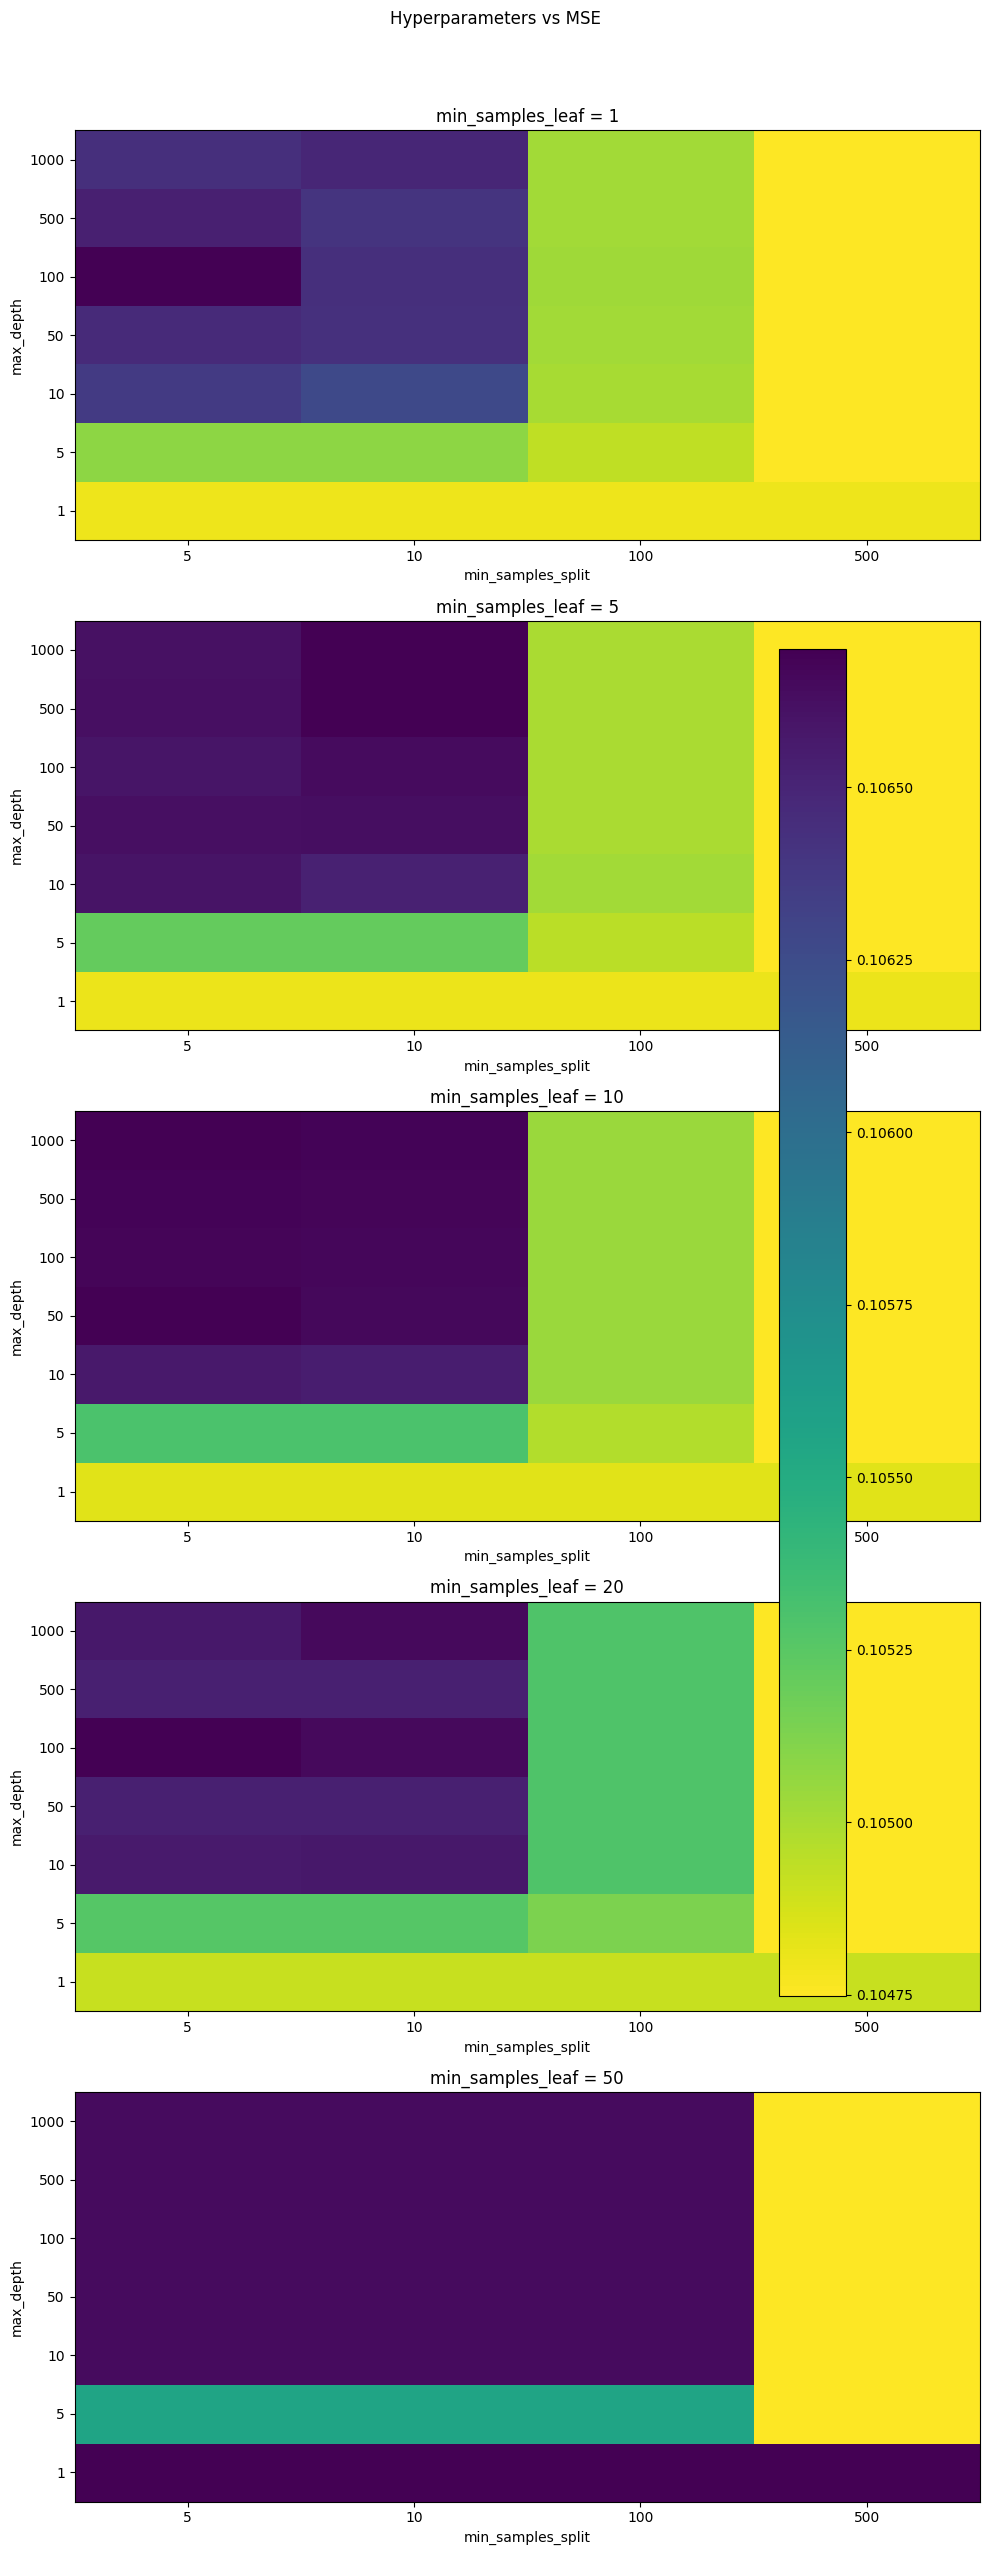

In [ ]:

# Create a 3D matrix to store the Mean Squared Errors for each combination of hyperparameters
mse_matrix = np.zeros((len(max_depth), len(min_samples_split), len(min_samples_leaf)))

# Fill the mse_matrix with values from cv_errors
for i, d in enumerate(max_depth):
    for j, s in enumerate(min_samples_split):
        for k, l in enumerate(min_samples_leaf):
            index = i * len(min_samples_split) * len(min_samples_leaf) + j * len(min_samples_leaf) + k
            mse_matrix[i, j, k] = cv_errors[index]

# Plot the results
fig, ax = plt.subplots(len(min_samples_leaf), figsize=(10, 5 * len(min_samples_leaf)))
plt.suptitle("Hyperparameters vs MSE", y=1.02)

for k, l in enumerate(min_samples_leaf):
    im = ax[k].imshow(mse_matrix[:, :, k], cmap='viridis_r', aspect='auto', origin='lower')
    ax[k].set_title(f'min_samples_leaf = {l}')
    ax[k].set_xticks(range(len(min_samples_split)))
    ax[k].set_xticklabels(min_samples_split)
    ax[k].set_yticks(range(len(max_depth)))
    ax[k].set_yticklabels(max_depth)
    ax[k].set_xlabel('min_samples_split')
    ax[k].set_ylabel('max_depth')

fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.7)
plt.tight_layout()
plt.show()

In [ ]:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 50,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 500,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [114]:
best_model.predict(example_embed)
#print first 10 comments and the corresponding predictions
for i in range(10):
    print(f'Prediction: {best_model.predict(example_embed)[i]}, Comment: {test_df_example["comment_text"].iloc[i]}')
    print("*"*50)

Prediction: 0.4298309252190684, Comment: Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,
**************************************************
Prediction: 0.30106953878544657, Comment: == From RfC == 

 The title is fine as it is, IMO.
**************************************************
Prediction: 0.2960395160626292, Comment: " 

 == Sources == 

 * Zawe Ashton on Lapland —  /  "
**************************************************
Prediction: 0.23173856490826655, Comment: :If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message.
*